<a href="https://colab.research.google.com/github/seymatttass/Plant_Detection/blob/main/vgg_16_ipynb_adl%C4%B1_dosyan%C4%B1n_kopyas%C4%B1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, BatchNormalization, Dropout
from keras.applications import VGG16
import matplotlib.pyplot as plt
import cv2
import numpy as np
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2

In [ ]:
train_path = '/content/drive/MyDrive/AYZEK-Kanarya/yeni_arttırılmış/train'
test_path = '/content/drive/MyDrive/AYZEK-Kanarya/yeni_arttırılmış/test'
val_path = '/content/drive/MyDrive/AYZEK-Kanarya/yeni_arttırılmış/val'

In [ ]:
train_data_gen = ImageDataGenerator(rescale=1/255) # Ölçeklendirme
test_data_gen = ImageDataGenerator(rescale=1/255)
val_data_gen = ImageDataGenerator(rescale=1/255)


Görüntü veri işleme sürecinde, piksel değerleri genellikle 0 ile 255 arasında olur.
Ancak, bu değerlerin bir modelin eğitilmesi için uygun hale getirilmesi gerekir.
Bu nedenle, genellikle piksel değerlerini 0 ile 1 arasında olacak şekilde ölçeklendirilirler.
Bunu yapmanın bir yolu, piksel değerlerini 255'e bölmektir.
Yani, her piksel değeri 255'e bölünerek 0 ile 1 arasında bir değer elde edilir.
Bu nedenle, **`rescale(1/255)`** yöntemi, görüntü verilerinin piksel değerlerini yeniden ölçeklendirerek 0 ile 1 arasında bir değere dönüştürür.
Bu, modelin daha iyi öğrenme yapmasını sağlar, çünkü genellikle daha küçük sayılarla daha iyi performans elde edilir.

In [ ]:
train_generator = train_data_gen.flow_from_directory(
        train_path,
        target_size=(448, 448), # Görüntü boyutları
        batch_size=16,
        class_mode='categorical')  # Sınıf modu, çok sınıflı bir sınıflandırma olduğu için 'categorical'

Found 2292 images belonging to 4 classes.


👆🏻👆🏻👆🏻
Bir veri yükleyici (data loader) oluşturulur.
Bu yükleyici, belirtilen dizindeki görüntüleri yükler, onları belirtilen boyuta yeniden boyutlandırır,
belirtilen batch boyutunda gruplar halinde verir ve hedef sınıfları kategorik olarak kodlar.
Bu yükleyici daha sonra model eğitimi için kullanılabilir.

In [ ]:
test_generator = test_data_gen.flow_from_directory(
    test_path,
    target_size=(448, 448),  # Görüntü boyutları
    batch_size=16,
    class_mode='categorical'  # Sınıf modu, çok sınıflı bir sınıflandırma olduğu için 'categorical'
)

Found 306 images belonging to 4 classes.


In [ ]:
val_generator = val_data_gen.flow_from_directory(
    val_path,
    target_size=(448, 448),  # Görüntü boyutları
    batch_size=16,
    class_mode='categorical'  # Sınıf modu, çok sınıflı bir sınıflandırma olduğu için 'categorical'
)

Found 300 images belonging to 4 classes.


In [ ]:
vgg = VGG16(
    input_shape=(448, 448, 3),
    weights='imagenet',
    include_top=False)

58889256/58889256 [==============================] - 0s 0us/step


**include_top=False** olduğunda VGG16 modeli, tamamen bağlı katmanlar (fully connected layer'lar) olmadan oluşturulur.
Bu durumda, modelin sadece özellik çıkarma (feature extraction) kısmı oluşturulur.
Bu, modelin özellik çıkarma amacıyla kullanılmasını sağlar. Yani, bu model, görüntülerin düşük, orta ve yüksek seviyeli özelliklerini çıkarmak için kullanılabilir,
ancak sınıflandırma katmanları olmadığı için sınıflandırma yapamaz.

In [ ]:
model = Sequential()
model.add(vgg)
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(4 , activation='softmax'))

**softmax aktivasyon fonksiyonu** genellikle çok sınıflı sınıflandırma problemleri için kullanılır.
Bu fonksiyon, modelin çıktılarını olasılık dağılımına dönüştürerek, sınıf olasılıklarını hesaplamak için idealdir.
Özellikle sınıflandırma problemlerinde, modelin çıkışı sınıf etiketlerine karşılık gelen olasılıklar kümesi olarak yorumlanabilir.
softmax fonksiyonu, bu olasılıkların toplamının 1'e eşit olmasını sağlar, bu da her bir sınıf için bir olasılık dağılımı oluşturur.

**`BatchNormalization`** katmanı, normalleştirme işlemini gerçekleştirir. Her bir batch'teki (bir grup veri) özellik vektörlerinin ortalamasını sıfıra ve varyansını bir birime getirir. Bunu yaparak, her bir batch'in dağılımını daha istikrarlı hale getirir ve gradyanların daha tutarlı bir şekilde akmasını sağlar.

Normalleştirme işlemi, aşağıdaki adımlarla gerçekleştirilir:

- Ortalama Hesaplama: Her bir özellik (feature) boyunca batch içindeki özellik
vektörlerinin ortalaması hesaplanır.

- Varyans Hesaplama: Her bir özellik boyunca batch içindeki özellik vektörlerinin varyansı hesaplanır.

- Normalleştirme: Özellik vektörleri, ortalama değerden çıkarılarak (ortalamadan çıkarılarak) merkezlenir ve ardından varyansla bölünerek ölçeklenir.

- Ölçekleme ve Kaydırma: Normalleştirilmiş özellik vektörleri, bir ölçek (scale) ve bir kaydırma (shift) parametresi ile çarpılır ve eklenir. Bu parametreler, modelin öğrenilebilir parametreleridir ve her bir özellik kanalı için ayrı ayrı hesaplanır.

Bu adımlar, her bir batch'teki verilerin ortalamasını ve varyansını standartlaştırarak eğitim sürecini daha hızlı ve daha istikrarlı hale getirir. Sonuç olarak, modelin daha hızlı öğrenmesine ve daha iyi sonuçlar elde etmesine yardımcı olur.

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 14, 14, 512)       14714688  
                                                                 
 batch_normalization (Batch  (None, 14, 14, 512)       2048      
 Normalization)                                                  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 1024)              102761472 
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                        

In [ ]:
model.compile(optimizer='Adadelta', loss='categorical_crossentropy', metrics=['accuracy'])

Sınıflandırma problemleri için en yaygın olarak kullanılan optimizer genellikle **Adam optimizeridir.** Adam, adaptif öğrenme oranı ve momentumun bir kombinasyonunu kullanarak gradyan inişini gerçekleştirir. Bu, birçok sınıflandırma probleminde etkili sonuçlar veren güçlü bir optimizerdır.

Adam optimizerinin birkaç avantajı vardır:

- Hızlı ve Etkili: Adam, genellikle diğer optimizerlere kıyasla daha hızlı ve daha etkili bir şekilde eğitim sağlar.

- Adaptif Öğrenme Oranı: Adam, her parametre için ayrı ayrı adaptif bir öğrenme oranı sağlar. Bu, modelin hızlı ve dengeli bir şekilde eğitilmesine yardımcı olur.

- Momentumun Kullanımı: Adam, gradyanın momentumunu da dikkate alır, bu da eğitim sürecinin daha istikrarlı olmasına ve yerel minimumlara daha az sıkışmasına yardımcı olur.

- Parametre Düzenleme: Adam, genellikle overfitting'i azaltmaya yardımcı olan parametre düzenleme (regularization) özelliğine sahiptir.


**`1) Gradyan:`** Bir fonksiyonun en büyük artışını gösteren vektör. Türevi alınan bir fonksiyonun gradyanı, fonksiyonun artış hızının en büyük olduğu yönü gösterir. Eğitim sürecinde gradyan, modelin kaybını (loss) azaltmak için parametrelerin (ağırlıkların) güncellenmesinde kullanılır. Gradyanın tersine çevrilmiş yönü, kaybı azaltan bir yöndür, bu nedenle gradyan inişi, modelin kaybını azaltmak için gradyanın negatif yönünde adımlar atar.

**`2) Momentum:`** Momentum, gradyan inişinde bir tür ivme sağlayan bir parametredir. Momentum, mevcut gradyan değerinin bir kısmını (genellikle 0 ile 1 arasında bir değer) korur ve yeni gradyan değerini bu ivme ile birleştirir. Bu, gradyan inişini daha hızlı ve daha istikrarlı hale getirir, özellikle yerel minimumlardan kaçınma ve düz çanaklarda hızlanma gibi durumlarda faydalıdır.



In [ ]:
checkpoint = ModelCheckpoint(
    f'/content/drive/MyDrive/AYZEK-Kanarya/models/vgg-16/vgg16_model_yeni9.h5',
     monitor='val_accuracy',
     verbose=1,
     save_best_only=True,
     mode = 'max'
)

**monitor:** Modelin performansını izlemek için kullanılan metriği belirtir. Örneğin, 'val_accuracy' olarak belirtilirse, doğrulama veri seti üzerinde doğruluk (accuracy) metriği izlenir ve bu metriğin en iyi olduğu durumlarda model kaydedilir.

**verbose:** Kullanıcıya ilerleme durumu hakkında bilgi verir. Değer 0 ise sessiz mod, 1 ise ilerleme çubuğu, 2 ise her bir epoch için bir satır çıktı sağlar.

In [ ]:
earlystop = EarlyStopping(monitor='val_accuracy',
                          patience=10,
                          verbose=1,
                          mode = 'max')

**EarlyStopping**, eğitim sırasında modelin aşırı uyum (overfitting) yapmasını önlemek için kullanılan bir Keras geri çağırısıdır. Eğitim sürecinde modelin performansını izler ve belirli bir kriteri karşıladığında (örneğin, doğrulama setindeki doğruluk belirli bir süre boyunca artmazsa veya kayıp belirli bir süre boyunca azalmazsa), eğitimi otomatik olarak durdurur.

In [ ]:
from keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001)

In [ ]:
result = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=25,
    callbacks = [earlystop, checkpoint])

Epoch 1/25
143/143 [==============================] - ETA: 0s - loss: 1.1161 - accuracy: 0.5330
Epoch 1: val_accuracy improved from -inf to 0.61806, saving model to /content/drive/MyDrive/AYZEK-Kanarya/models/vgg-16/vgg16_model_yeni9.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


143/143 [==============================] - 1036s 7s/step - loss: 1.1161 - accuracy: 0.5330 - val_loss: 1.0742 - val_accuracy: 0.6181
Epoch 2/25
143/143 [==============================] - ETA: 0s - loss: 0.6257 - accuracy: 0.7667
Epoch 2: val_accuracy improved from 0.61806 to 0.78125, saving model to /content/drive/MyDrive/AYZEK-Kanarya/models/vgg-16/vgg16_model_yeni9.h5
143/143 [==============================] - 142s 990ms/step - loss: 0.6257 - accuracy: 0.7667 - val_loss: 0.7662 - val_accuracy: 0.7812
Epoch 3/25
143/143 [==============================] - ETA: 0s - loss: 0.4592 - accuracy: 0.8304
Epoch 3: val_accuracy improved from 0.78125 to 0.80208, saving model to /content/drive/MyDrive/AYZEK-Kanarya/models/vgg-16/vgg16_model_yeni9.h5
143/143 [==============================] - 137s 953ms/step - loss: 0.4592 - accuracy: 0.8304 - val_loss: 0.5740 - val_accuracy: 0.8021
Epoch 4/25
143/143 [==============================] - ETA: 0s - loss: 0.3507 - accuracy: 0.8915
Epoch 4: val_accuracy

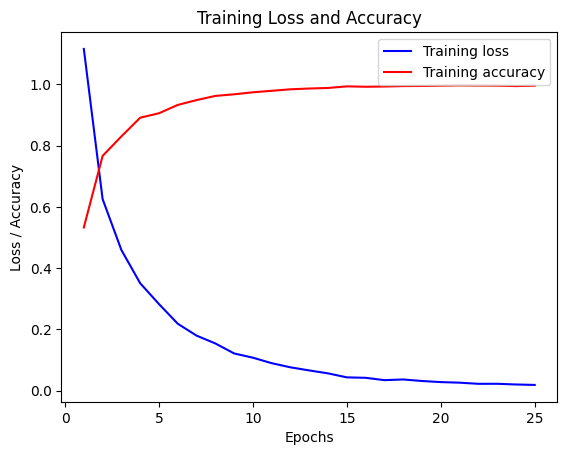

In [ ]:
train_loss = result.history['loss']
train_accuracy = result.history['accuracy']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, train_accuracy, 'r', label='Training accuracy')
plt.title('Training Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss / Accuracy')
plt.legend()

plt.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

vgg_model_yeni7 --> 94

batchsize 16'dan 32'ye çıkardım


In [ ]:
"""# model ile tahmin etme
predictions = model.predict(test_generator)

# test verileri ve tahmin edilen değerler arasındaki karşılaştırma
num_samples_to_visualize = 20
test_labels = []  # Gerçek değerleri tutan boş liste
predicted_labels = []  # Tahmin edilen değerleri tutan boş liste

# test datalarından örnekler
for i, (_, labels) in enumerate(test_generator):
    test_labels.extend(labels.argmax(axis=1))  # Gerçek etiketleri al
    predicted_labels.extend(predictions.argmax(axis=1))  # Tahmin edilen etiketleri al
    if i == num_samples_to_visualize - 1:
        break

# Sonuçları görselleştir
plt.figure(figsize=(12, 8))
for i in range(num_samples_to_visualize):
    plt.subplot(5, 4, i + 1)
    plt.imshow(test_generator[i][0][0])  # Test resmini göster
    plt.title(f'Real: {test_labels[i]}, Predicted: {predicted_labels[i]}')
    plt.axis('off')

plt.tight_layout()
plt.show()
"""